In [1]:
# Vehicle Detection - Kevin Lee
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
import time
import random

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

%matplotlib inline

In [2]:
# Udacity lesson functions

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [3]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    boxes = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return boxes

In [4]:
# load training data
vehicles = glob.glob('training_data/vehicles/**/*.png')
non_vehicles = glob.glob('training_data/non-vehicles/**/*.png')
print('Vehicles: {}, Non-Vehicles: {}'.format(len(vehicles), len(non_vehicles)))

Vehicles: 8792, Non-Vehicles: 8968


Balanced dataset, no need to upsample or downsample

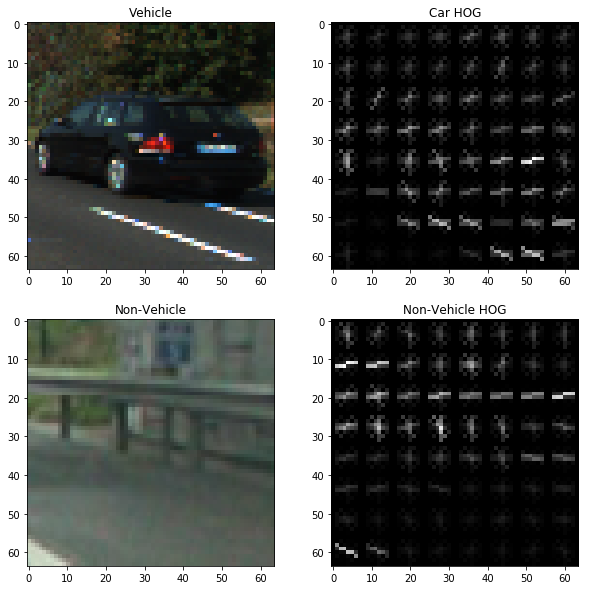

In [5]:
# Show a random vehicle/non-vehicle image and corresponding HOG
rand_ind = random.randint(1, len(vehicles))

vehicle_img = mpimg.imread(vehicles[rand_ind])
_, vehicle_hog = get_hog_features(vehicle_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
nonvehicle_img = mpimg.imread(non_vehicles[rand_ind])
_, nonvehicle_hog = get_hog_features(nonvehicle_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
ax[0].imshow(vehicle_img)
ax[0].set_title('Vehicle')
ax[1].imshow(vehicle_hog, cmap='gray')
ax[1].set_title('Car HOG')
ax[2].imshow(nonvehicle_img)
ax[2].set_title('Non-Vehicle')
ax[3].imshow(nonvehicle_hog, cmap='gray')
ax[3].set_title('Non-Vehicle HOG')

In [6]:
# Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t1 = time.time()
car_features = extract_features(vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to extract features')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
# rand_state = np.random.randint(0, 100)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=rand_state)
    
# # Fit a per-column scaler
# X_scaler = StandardScaler().fit(X_train)
# # Apply the scaler to X
# X_train = X_scaler.transform(X_train)
# X_test = X_scaler.transform(X_test)

# print('Using:',orient,'orientations',pix_per_cell,
#     'pixels per cell and', cell_per_block,'cells per block')
# print('Feature vector length:', len(X_train[0]))

# Fit on all data (will use grid search)
X_scaler = StandardScaler().fit(X)
X = X_scaler.transform(X)

147.71 Seconds to extract features


In [7]:
# Shuffle full dataset for training
X,y = shuffle(X,y)

In [36]:
# Use a linear SVC 
svc = LinearSVC(C=0.01, loss='squared_hinge')
# Check the training time for the SVC
t3 = time.time()
svc.fit(X, y)
t4 = time.time()
print(round(t4-t3, 2), 'Seconds to train SVC')
# Check the score of the SVC
# print('Test Accuracy of SVC = ', round(svc.score(X, y), 4))
# # Check the prediction time for a single sample

37.57 Seconds to train SVC


In [29]:
# # Use a general SVC
# svc1 = SVC()
# # Check the training time for the SVC
# t7 = time.time()
# svc1.fit(X_train, y_train)
# t8 = time.time()
# print(round(t8-t7, 2), 'Seconds to train SVC')
# # Check the score of the SVC
# print('Test Accuracy of SVC = ', round(svc1.score(X_test, y_test), 4))
# # Check the prediction time for a single sample

31.2 Seconds to train SVC
Test Accuracy of SVC =  0.9904


In [8]:
# Random Forest Test
#rf = RandomForestClassifier(min_samples_leaf=1, min_samples_split=7, n_estimators=100)
rf = RandomForestClassifier(min_samples_leaf=1, min_samples_split=7, n_estimators=50)
t5 = time.time()
rf.fit(X, y)
t6 = time.time()
print(round(t6-t5, 2), 'Seconds to train RF')
# Check the score of the SVC
# print('Test Accuracy of RF = ', round(rf.score(X, y), 4))

124.61 Seconds to train RF


In [34]:
param_grid = {"n_estimators":[25, 50, 75],
              "min_samples_split": [5,7,9],
              "min_samples_leaf": [1,3,5],}

rf1 = RandomForestClassifier(n_jobs=3)

## timer for grid searching
gs = GridSearchCV(rf1, param_grid, verbose=5)
gs.fit(X, y)

## used with grid search
print(gs.best_score_)
print(gs.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] min_samples_leaf=1, min_samples_split=5, n_estimators=25 ........
[CV]  min_samples_leaf=1, min_samples_split=5, n_estimators=25, score=0.9851376456679615, total=  15.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.3s remaining:    0.0s


[CV] min_samples_leaf=1, min_samples_split=5, n_estimators=25 ........
[CV]  min_samples_leaf=1, min_samples_split=5, n_estimators=25, score=0.9856418918918919, total=  15.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.8s remaining:    0.0s


[CV] min_samples_leaf=1, min_samples_split=5, n_estimators=25 ........
[CV]  min_samples_leaf=1, min_samples_split=5, n_estimators=25, score=0.9832742017232641, total=  16.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   49.7s remaining:    0.0s


[CV] min_samples_leaf=1, min_samples_split=5, n_estimators=50 ........
[CV]  min_samples_leaf=1, min_samples_split=5, n_estimators=50, score=0.9861509880087823, total=  31.2s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s


[CV] min_samples_leaf=1, min_samples_split=5, n_estimators=50 ........
[CV]  min_samples_leaf=1, min_samples_split=5, n_estimators=50, score=0.9853040540540541, total=  32.6s
[CV] min_samples_leaf=1, min_samples_split=5, n_estimators=50 ........
[CV]  min_samples_leaf=1, min_samples_split=5, n_estimators=50, score=0.9851326237540124, total=  31.3s
[CV] min_samples_leaf=1, min_samples_split=5, n_estimators=75 ........
[CV]  min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.9842931937172775, total=  45.8s
[CV] min_samples_leaf=1, min_samples_split=5, n_estimators=75 ........
[CV]  min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.9864864864864865, total=  46.3s
[CV] min_samples_leaf=1, min_samples_split=5, n_estimators=75 ........
[CV]  min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.9866531508700794, total=  48.0s
[CV] min_samples_leaf=1, min_samples_split=7, n_estimators=25 ........
[CV]  min_samples_leaf=1, min_samples_split=7, n_estim

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 40.1min finished


0.986204954955
{'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 75}


In [37]:
gs.cv_results_

{'mean_fit_time': array([ 15.69133798,  31.52121472,  46.39809887,  19.22886984,
         31.30589628,  44.67264175,  16.27211499,  30.59722813,
         46.96386949,  15.00727661,  28.05075487,  42.40687768,
         14.38370474,  28.40113107,  40.27183485,  14.43507854,
         27.48553673,  40.82659245,  15.74990749,  26.98417099,
         39.41275247,  14.00774654,  25.84617829,  40.23806699,
         14.18359057,  26.27837467,  37.32769235]),
 'mean_score_time': array([ 0.33449292,  0.29247316,  0.40641061,  0.2941517 ,  0.26369842,
         0.39912836,  0.28617978,  0.28065093,  0.40427184,  0.30269829,
         0.29960227,  0.42004601,  0.2936341 ,  0.30231222,  0.4138693 ,
         0.29139264,  0.31234654,  0.43536957,  0.31978703,  0.36892716,
         0.41317979,  0.28139607,  0.29962556,  0.43190726,  0.31164201,
         0.326238  ,  0.41381733]),
 'mean_test_score': array([ 0.98468468,  0.98552928,  0.98581081,  0.98457207,  0.98541667,
         0.98614865,  0.98462838,  

In [35]:
param_grid = {'C':[0.01, 0.05, 0.1, 1.0], 'loss':['hinge','squared_hinge']}

svc1 = LinearSVC()

## timer for grid searching
gs1 = GridSearchCV(svc1, param_grid, cv=5, verbose=5)
gs1.fit(X, y)

## used with grid search
print(gs1.best_score_)
print(gs1.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=0.01, loss=hinge ..............................................
[CV] ...... C=0.01, loss=hinge, score=0.983957219251337, total=  18.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.0s remaining:    0.0s


[CV] C=0.01, loss=hinge ..............................................
[CV] ..... C=0.01, loss=hinge, score=0.9836757669575007, total=  15.5s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   35.0s remaining:    0.0s


[CV] C=0.01, loss=hinge ..............................................
[CV] ..... C=0.01, loss=hinge, score=0.9831081081081081, total=  22.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   57.9s remaining:    0.0s


[CV] C=0.01, loss=hinge ..............................................
[CV] ..... C=0.01, loss=hinge, score=0.9831033511686849, total=  19.9s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


[CV] C=0.01, loss=hinge ..............................................
[CV] ..... C=0.01, loss=hinge, score=0.9825401295409744, total=  18.9s
[CV] C=0.01, loss=squared_hinge ......................................
[CV]  C=0.01, loss=squared_hinge, score=0.9833943146636646, total=  31.8s
[CV] C=0.01, loss=squared_hinge ......................................
[CV]  C=0.01, loss=squared_hinge, score=0.9848015761328455, total=  33.3s
[CV] C=0.01, loss=squared_hinge ......................................
[CV]  C=0.01, loss=squared_hinge, score=0.9833896396396397, total=  31.7s
[CV] C=0.01, loss=squared_hinge ......................................
[CV]  C=0.01, loss=squared_hinge, score=0.9847930160518164, total=  30.0s
[CV] C=0.01, loss=squared_hinge ......................................
[CV]  C=0.01, loss=squared_hinge, score=0.9828217403548296, total=  33.2s
[CV] C=0.05, loss=hinge ..............................................
[CV] ...... C=0.05, loss=hinge, score=0.983957219251337, total

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 17.0min finished


0.98384009009
{'C': 0.01, 'loss': 'squared_hinge'}


In [7]:
# test_img = mpimg.imread('./test_images/test2.jpg')

# ystart = 400
# ystop = 500
# # def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

# test_img_rects = draw_boxes(test_img, rectangles)
# plt.figure(figsize=(10,10))
# plt.imshow(test_img_rects)

In [9]:
# Function to show the test images in a subplot
def show_images(images, cmap=None):
    fig, ax = plt.subplots(3, 2, figsize=(15, 15))
    ax = ax.ravel()
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap=cmap)

In [10]:
def sliding_windows(img, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bboxes = []
    bboxes += find_cars(img, 400, 500, 0.8, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes += find_cars(img, 400, 500, 1.0, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes += find_cars(img, 400, 525, 1.2, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes += find_cars(img, 400, 550, 1.5, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes += find_cars(img, 450, 600, 1.5, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes += find_cars(img, 450, 650, 2.0, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes += find_cars(img, 500, 650, 2.5, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    img_rects = draw_boxes(img, bboxes)
    return img_rects, bboxes
    
# sliding_windows_img = mpimg.imread('./test_images/test2.jpg')
# sliding_windows(sliding_windows_img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

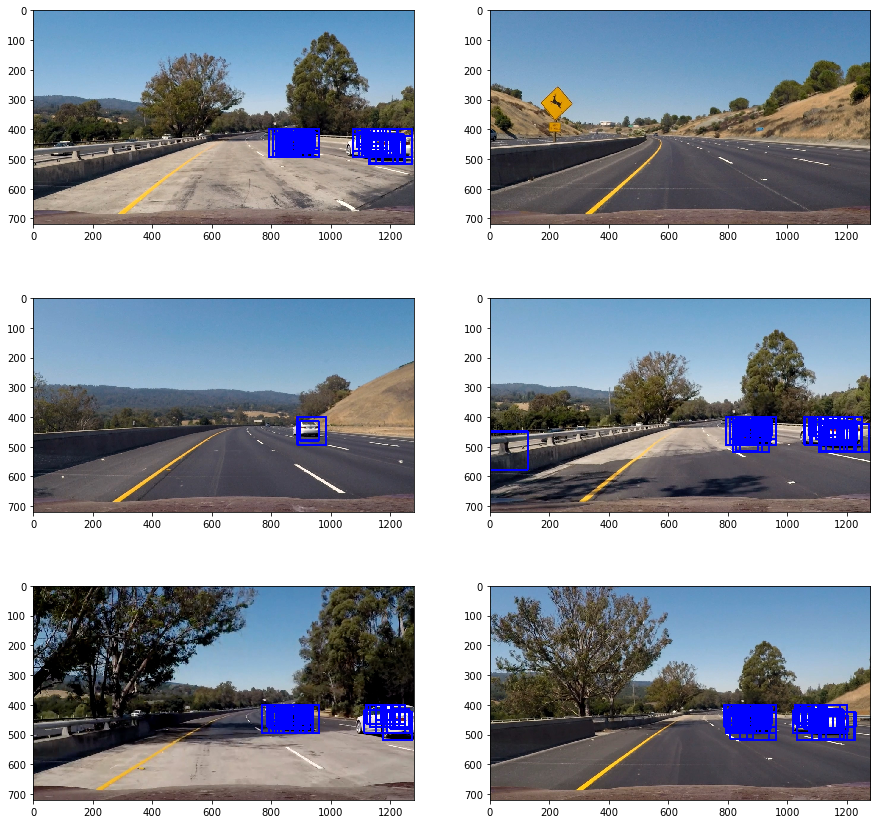

In [11]:
images_location = glob.glob('test_images/*.jpg')
test_images = []
detect_images = []
bboxes_total = []
for img_path in images_location:
    img = mpimg.imread(img_path)
    test_images.append(img)
    windows_img, bboxes = sliding_windows(img, rf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    detect_images.append(windows_img)
    bboxes_total.append(bboxes)
    
show_images(detect_images)

This Random Forest Classifier does a good job of recognizing the vehicles present in the images with few false negatives.

In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

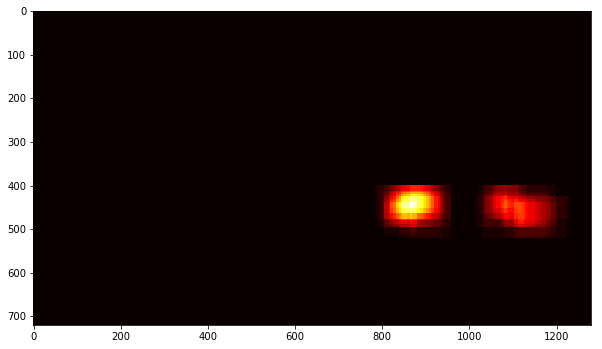

In [13]:
heatmap_img = np.zeros_like(test_images[5][:,:,0])
heatmap_img = add_heat(heatmap_img, bboxes_total[5])
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

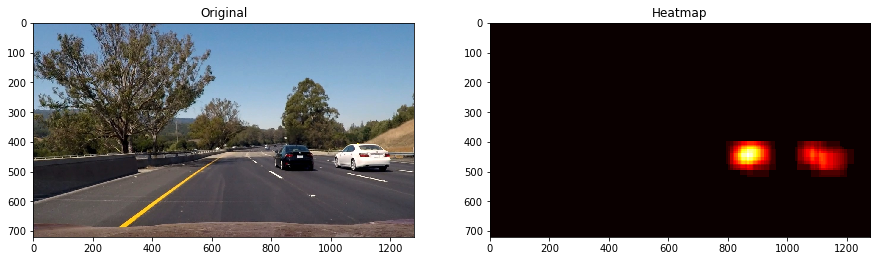

In [14]:
heatmap_img = apply_threshold(heatmap_img, 1)
fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(test_images[5])
ax[0].set_title('Original')
ax[1].imshow(heatmap_img, cmap='hot')
ax[1].set_title('Heatmap')
#plt.imshow(heatmap_img, cmap='hot')

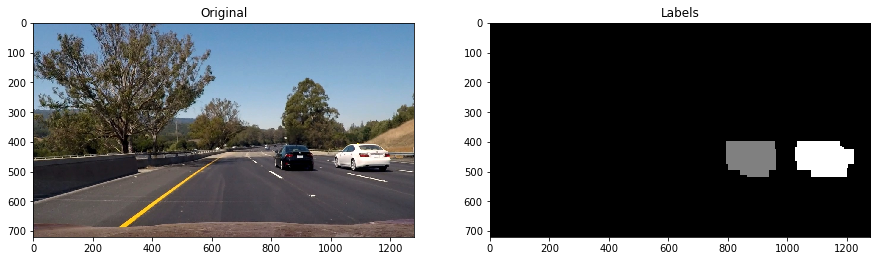

In [15]:
labels = label(heatmap_img)
fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(test_images[5])
ax[0].set_title('Original')
ax[1].imshow(labels[0], cmap='gray')
ax[1].set_title('Labels')
#plt.figure(figsize=(10,10))
#plt.imshow(labels[0], cmap='gray')

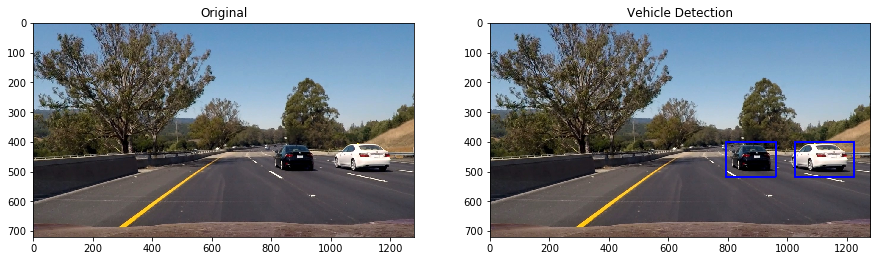

In [16]:
draw_img, rect = draw_labeled_bboxes(np.copy(test_images[5]), labels)
# Display the image
fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(test_images[5])
ax[0].set_title('Original')
ax[1].imshow(draw_img)
ax[1].set_title('Vehicle Detection')
# plt.figure(figsize=(10,10))
# plt.imshow(draw_img)

In [17]:
from collections import deque

class Vehicle():
    def __init__(self):
        # store previous 15 
        self.prev_bboxes = deque([], maxlen=15)
        self.non_detect_frames = 0

In [21]:
def frame_pipeline(img):
    boxes_img, bboxes = sliding_windows(img, rf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    if len(bboxes) > 0:
        vehicle.prev_bboxes.append(bboxes)
        # reset non_detect_frames
        vehicle.non_detect_frames = 0
    else:
        vehicle.non_detect_frames += 1
    heatmap_img = np.zeros_like(boxes_img[:,:,0])
    for box in vehicle.prev_bboxes:
        heatmap_img = add_heat(heatmap_img, box)
    heatmap_img = apply_threshold(heatmap_img, 2 + len(vehicle.prev_bboxes) // 2)
    # heatmap_img = apply_threshold(heatmap_img, 3)
    # vehicle.prev_bboxes.append(heatmap_img)
#     current_heatmap = np.zeros_like(heatmap_img).astype(np.float)
#     for heatmap in vehicle.prev_bboxes:
#         current_heatmap += heatmap
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    if vehicle.non_detect_frames > 1:
        return img
    else:
        return draw_img

In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

vehicle = Vehicle()
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(frame_pipeline)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [03:40<00:05,  5.78s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 3min 42s


In [20]:
vehicle = Vehicle()
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(frame_pipeline)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [2:14:55<00:06,  6.22s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 2h 14min 57s
